In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from decimal import *
import scipy.special
import scipy.stats
import scipy
import numpy
import math
import itertools

In [2]:
import sys
sys.version

'3.8.10 (default, Jun 22 2022, 20:18:18) \n[GCC 9.4.0]'

# Out-of-band P2W attack evaluation

## P2W attack success probability within $ N $ total blocks (no attacker hash rate $\alpha$ )

* $\omega$ This denotes the hash rate of all bribed miners (or the hashrate of the attacker if applicable)
* $\beta = 1 -
\omega$ The hash rate of the nodes that keep on mining on the main chain i.e., Bob if all others switch
* $k$ The number of conirmations blocks required to catch up 
* $N$ The total number of blocks that can be rewarded  

A new block is appended to the *main chain* with probability:
$$
\dfrac{\beta}{\omega+\beta}  = \beta
$$

A new block is appended to the *attack cahin* with probability:
$$
\dfrac{\omega}{\omega+\beta} = \omega
$$

All successful series of blocks up to the maximum number of blocks $ N - n $ are given by:
$$
\sum_{i=0}^{i \le N - k -1}
 {
	 \left(\binom{k+2i}{i} - \binom{k+2i}{i-1}\right)
	 \cdot 
	 { \omega }^{k+1+i}
	 \cdot 
	 { \beta }^{i}
 }
 \,\,.
$$

In [3]:
# Attack probability of catching-up k blocks within N total blocks
def attack_prob(k,N,omega,beta=None):
    if beta is None:
        beta = 1 - omega
    p = 0
    #for i in range(0,N-k):
    i = 0
    while i <= N-k-1:
        p += ( scipy.special.binom(k+2*i, i) - scipy.special.binom(k+2*i, i-1) ) * omega**(k+i+1) * beta**i
        #print(i,p)
        i += 1
    return p

In [4]:
assert math.isclose(attack_prob(2,3,0.8,0.2),0.512)
assert math.isclose(attack_prob(2,4,0.8,0.2),0.7577600000000001)
assert math.isclose(attack_prob(2,5,0.8,0.2),0.8757248000000003)
assert math.isclose(attack_prob(2,6,0.8,0.2),0.9344450560000004)
assert math.isclose(attack_prob(2,7,0.8,0.2),0.9646440448000003)

In [5]:
attack_prob(2,3,0.8,0.2)

0.5120000000000001

In [6]:
attack_prob(1,200,0.1)

0.01234567901234568

In [7]:
attack_prob(k=6,N=6,omega=0.670)

0

In [8]:
attack_prob(k=6,N=7,omega=0.670)

0.06060711605323003

In [9]:
# Get number of required total blocks s.t. attack success probability is met 
def attack_N(k,omega,success_prob):
        N = 0
        prob = 0
        while prob < success_prob:
            #prob = probCalc_optimized.compute_prob(k, N, omega,beta=1-omega)
            prob = attack_prob(k, N, omega,beta=1-omega)
            N += 1
        # the last N value produces the right prob not the current one, therefore -1
        return N - 1

In [10]:
attack_N(k=6,omega=0.532,success_prob=0.995)

515

In [11]:
attack_N(k=6,omega=0.67,success_prob=0.995)

41

In [12]:
attack_N(k=6,omega=0.67,success_prob=1)

265

In [13]:
# calculate expected number of blocks in which attack is successful i.e., target sucess probability is reached with this amount of N
def attack_expected_estimate(k,N,omega,beta=None):
    if beta is None:
        beta = 1 - omega
    P = 0
    p = 0
    e = 0
    i = 0
    while i <= N-k-1:
        # Current success probability:
        p = ( scipy.special.binom(k+2*i, i) - scipy.special.binom(k+2*i, i-1) ) * omega**(k+i+1) * beta**i
        # Overall target success probability:
        P += p
        # Expected value:
        # y is the real current value of blocks passed
        # this is why we need to add k+1 to y 
        # to account for the k+1 in the formular and the loop condition
        y = i+k+1
        if math.isnan(p):
            print("p isnan P=",P," e=",e)
            return e
        e += p * y
        #print(P,p,i,y,e)
        i += 1
        p = 0
    return e

In [14]:
math.ceil(attack_expected_estimate(k=6,N=41,omega=0.670))

14

In [15]:
math.ceil(attack_expected_estimate(k=6,N=265,omega=0.670))

14

In [16]:
math.ceil(attack_expected_estimate(k=6,N=500,omega=0.670))

14

In [17]:
math.ceil(attack_expected_estimate(k=6,N=500,omega=0.764))

11

In [18]:
math.ceil(attack_expected_estimate(k=6,N=500,omega=0.828))

9

In [19]:
math.ceil(attack_expected_estimate(k=6,N=500,omega=0.887))

9

In [20]:
import numpy as py

def simulate_race(p_omega = 0.670, # rational hashrate 
                  k_v = 6,
                  runs = 1):
    p_beta = 1-p_omega
    i=0
    results={"mblk":0,
             "ablk":0,
             "N":0}
    while (i<runs):
        achain = 0
        mchain = k_v 
        #results["mblk"] = k_v
        while(achain <= mchain):
            values = np.random.choice([0,1],1,p=[p_beta,p_omega])

            for v in values:
                if v == 0:
                    mchain += 1
                    results["mblk"] += 1
                else:
                    achain +=1
                    results["ablk"] += 1
            results["N"] += 1
        i += 1
    return results
    
simulate_race()

{'mblk': 8, 'ablk': 15, 'N': 23}

In [21]:
runs=10**4
%time simulate_race(p_omega=0.532,runs=runs)["N"]/runs

CPU times: user 39.9 s, sys: 513 ms, total: 40.4 s
Wall time: 39.2 s


110.5698

In [22]:
runs=10**5
%time simulate_race(p_omega=0.670,runs=runs)["N"]/runs

CPU times: user 1min 19s, sys: 630 ms, total: 1min 20s
Wall time: 1min 18s


20.64246

In [23]:
runs=10**5
%time simulate_race(p_omega=0.764,runs=runs)["N"]/runs

CPU times: user 56.5 s, sys: 303 ms, total: 56.8 s
Wall time: 56.2 s


13.2722

In [24]:
runs=10**5
%time simulate_race(p_omega=0.828,runs=runs)["N"]/runs

CPU times: user 47.2 s, sys: 406 ms, total: 47.6 s
Wall time: 46.9 s


10.67198

In [25]:
runs=10**5
%time simulate_race(p_omega=0.887,runs=runs)["N"]/runs

CPU times: user 38.6 s, sys: 325 ms, total: 39 s
Wall time: 38.2 s


9.04636

In [26]:
runs=10**5
%time simulate_race(p_omega=0.999,runs=runs)["N"]/runs

CPU times: user 29 s, sys: 185 ms, total: 29.2 s
Wall time: 28.8 s


7.01372

In [27]:
def attack_expected(k,N,omega,beta=None,runs=10**3):
    return math.ceil(simulate_race(p_omega=omega,runs=runs)["N"]/runs)

In [28]:
attack_expected(k=6,N=265,omega=0.670)

21

### Compare with classical catch-up

General catch up condition $ a_z $ from:
* https://arxiv.org/pdf/1402.2009.pdf
* https://bitcoin.org/bitcoin.pdf


Classical parameter names:
* $p$ = hashrate of the honest network
* $q$ = hashrate of the attacker
$$
p + q = 1
$$
* $n$ = number of confirmation blocks, including and on top of the block which includes the respective transaction which needs to be confirmed or double-spend respectively

The probability to **ever** catch-up if $ z $ blocks behind, where one block is added to $z$ when the honest miners find a block and one block is substracted from $ z $ when the attacker finds a block i.e.,

The catch-up probability is a simplification of the *recurrance relation*, where $ q = \alpha $ and $ p = \beta $, given as:
$$
\begin{align}
    a_z &= p \cdot a_{z+1} + q \cdot a_{z-1} \\
        &= min(q/q,1)^{max(z+1,0)} 
\end{align}
$$

In [29]:
def catch_up(q,z):
    if q >= 0.5:
        return 1.0
    return ( q/(1-q) )**(z+1)

With $ p \geq 0.5 $ of hashpower the attacker will always catch up:

In [30]:
assert catch_up(0.5,100)*100 == 100.0
catch_up(0.5,100)*100 

100.0

With $ p < 0.5 $ of hashpower the probability drops exponentially with $ z $:

In [31]:
catch_up(0.49,6)*100 

75.57555192825632

In [32]:
catch_up(0.49,12.5)*100 

58.27062859382228

In [33]:
catch_up(0.49,25)*100 

35.34056612095472

In [34]:
catch_up(0.49,50)*100 

12.999333939026162

In [35]:
catch_up(0.49,100)*100 

1.7587993521988143

#### Comparision

In [36]:
# Probability to catch up 1 blocks i.e., 1 block behind in unlimited time/blocks
catch_up(q=0.33,z=1)*100

24.259300512363563

In [37]:
# Probability to catch up 1 blocks i.e., 1 block behind in (large) limited time/blocks
attack_prob(1,100,0.33)*100

24.259299518743187

In [38]:
# Probability to catch up 1 blocks i.e., 1 block behind in unlimited time/blocks
catch_up(q=0.66,z=1)*100

100.0

In [39]:
# Probability to catch up 1 blocks i.e., 1 block behind in limited time/blocks i.e., 12
attack_prob(1,12,0.66)*100

96.29614818620146

### Comparison of catching-up within $ N $ total blocks vs catching-up after $ \infty $ blocks

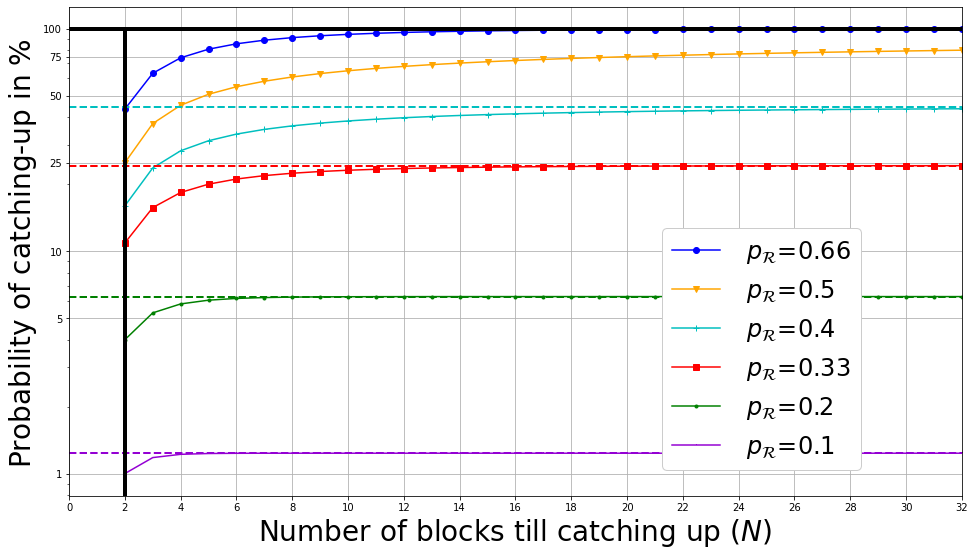

In [40]:
def fig_prob_to_catch_up():
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # https://matplotlib.org/api/markers_api.html
    marker = itertools.cycle(('o','v', '+', 's','.', ',', '*','1','D','x','^'))
    
    omega = [ 0.1, 0.2, 0.33, 0.4, 0.5, 0.66 ]
    N = np.arange(0,33)
    
    color = itertools.cycle(( 'b','orange','c','r', 'g','darkviolet',)) 
    """
    NUM_COLORS = len(omega)
    cm = plt.get_cmap('gist_rainbow') 
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    color = iter(colors)
    #ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    """    
    for o in reversed(omega):
        current_color=next(color)
        plt.plot(N, [ attack_prob(1,n,o)*100 for n in N ] , color=current_color, marker=next(marker), label=" $p_{\mathcal{R}}$=" + str(o))
        P = catch_up(o,1)*100
        plt.plot([0, len(N)], [P, P], color=current_color, linestyle='--', linewidth=2)
    
    plt.plot([2, 2], [-2, 100], color='k', linestyle='-', linewidth=4)
    plt.plot([0, 100], [100, 100], color='k', linestyle='-', linewidth=4)
    #plt.plot([0, 50], [50, 50], color='k', linestyle='--', linewidth=3)
        
    # tidy up the figure
    ax.grid(True)
    #ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.57))
    ax.legend(loc='center right', bbox_to_anchor=(0.90, 0.30), framealpha=1, prop={'size': 24} )
    #ax.set_title("Probability of catching-up 1 block after $ N $ total blocks")
    ax.set_ylabel("Probability of catching-up in $ \% $ ", fontsize=28)
    ax.set_xlabel("Number of blocks till catching up ($ N $)", fontsize=28)
    ax.set_yscale('log'), 
    #ax.set_ylim([-1,81])
    ax.set_yticks([1,5,10,25,50,75,100])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlim([0,len(N)-1])
    
    # draw line at 0 
    #plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
    #plt.plot([0, 100], [0, 0], color='k', linestyle='--', linewidth=2)
    
    #plt.yticks(np.arange(-1, 15, step=1))
    plt.xticks(np.arange(0, len(N), step=2))
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 23})
    plt.rc('xtick', labelsize=24) 
    plt.rc('ytick', labelsize=24) 
    plt.savefig("plots/number_of_blocks_for_catching-up_z=1.png", bbox_inches='tight',dpi=100) 
    plt.show()

fig_prob_to_catch_up()

### P2W attack success probability plot

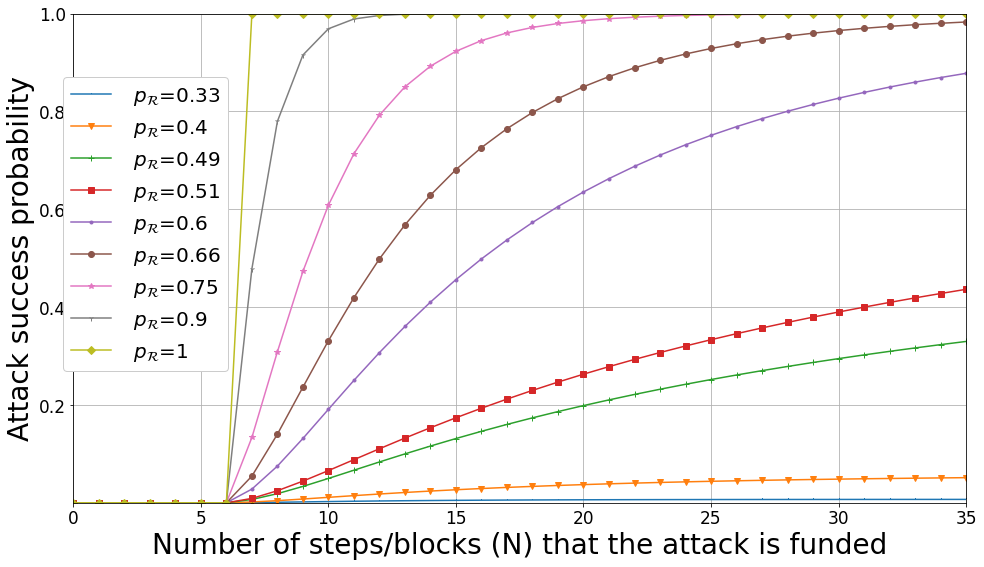

In [48]:
def fig_probability_success_after_at_most_N_steps():
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # https://matplotlib.org/api/markers_api.html
    marker = itertools.cycle((',','v', '+', 's','.', 'o', '*','1','D','x','^'))
    
    x = np.arange(0, 36)
    
    for omega in [0.33, 0.40, 0.49, 0.51, 0.6, 0.66, 0.75, 0.90, 1 ]:
        plt.plot(x, [ attack_prob(6, N, omega,beta=1-omega) for N in x ] , marker=next(marker), label=" $p_{\mathcal{R}}$=" + str(omega))

    # tidy up the figure
    ax.grid(True)
    #ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.57))
    ax.legend(loc='center right', bbox_to_anchor=(0.185, 0.57), framealpha=1, prop={'size': 20})
    #ax.set_title("Attack success probability")
    ax.set_xlabel("Number of steps/blocks (N) that the attack is funded", fontsize=28)
    ax.set_ylabel("Attack success probability",fontsize=28)
    ax.set_ylim([1e-10, 1])
    ax.set_xlim([0,35])
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 17})
    plt.rc('xtick', labelsize=17) 
    plt.rc('ytick', labelsize=17) 
    plt.savefig("plots/attack_probability_no-hashrate_n=6_N=35.png", bbox_inches='tight', dpi=100) # sage image
    plt.show()

fig_probability_success_after_at_most_N_steps()

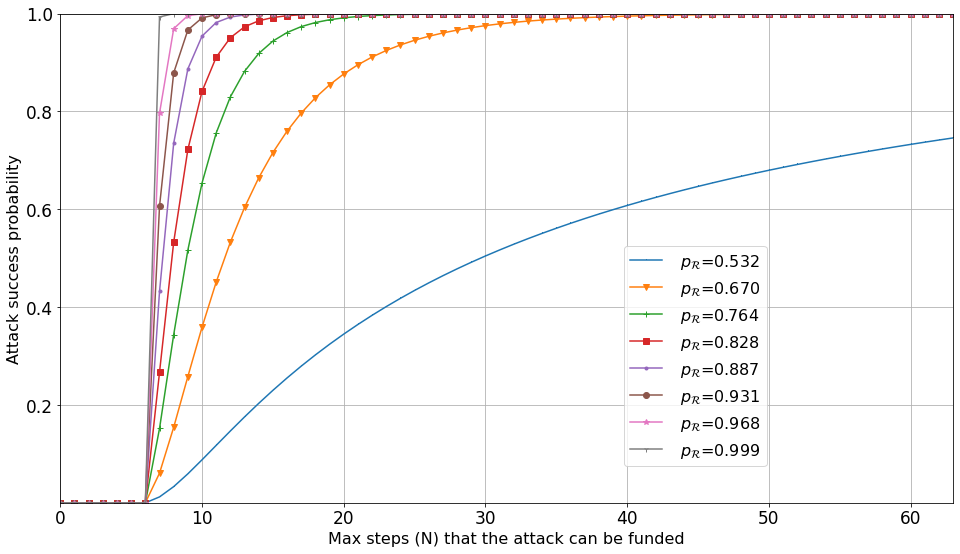

In [44]:
# This figure compares against the probabilities mentioned in the whale attack paper
# https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf

def fig_probability_success_after_at_most_N_steps():
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # https://matplotlib.org/api/markers_api.html
    marker = itertools.cycle((',','v', '+', 's','.', 'o', '*','1','D','x','^'))
    
    x = np.arange(0, 64)
    
    for omega in [0.532, 0.670, 0.764, 0.828, 0.887, 0.931, 0.968, 0.999 ]:
        plt.plot(x, [ attack_prob(6, N, omega,beta=1-omega) for N in x ] , marker=next(marker), label=" $p_{\mathcal{R}}$=" + "{:.3f}".format(omega))

    # tidy up the figure
    ax.grid(True)
    #ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.57))
    ax.legend(loc='center right', bbox_to_anchor=(0.80, 0.30))
    #ax.set_title("Attack success probability")
    ax.set_xlabel("Max steps (N) that the attack can be funded")
    ax.set_ylabel("Attack success probability")
    ax.set_ylim([1e-10, 1])
    ax.set_xlim([0,63])
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 17})
    plt.rc('xtick', labelsize=17) 
    plt.rc('ytick', labelsize=17) 
    plt.savefig("plots/attack_probability_no-hashrate_n=6_N=60.png", dpi=100) # sage image
    plt.show()

fig_probability_success_after_at_most_N_steps()

## Costs of the attack

Transaction exclusion and ordering attack costs for $ \omega = 1 $:

In [2]:
N = 6               # duration of the attack
#reward = 12.5       # block reward
reward = 6.25       # block reward
fee = 2             # average fees rounded to 1 (see other notebook) 
r_b = reward + fee
epsilon = 1         # bribe
c_operational = 0.5 # operational costs

f_B = N * ( r_b + epsilon )  + c_operational  # required funds of the attacker which are payed in Ethereum 

c_fail = N * r_b + c_operational

c_success = N * epsilon + c_operational

print("N              = ",N)
print("c_operational  = ",c_operational)
print("r_b            = ",r_b)
print("epsilon        = ",epsilon)
print("f_B            = ",f_B)
print("c_fail         = ",c_fail)
print("c_success      = ",c_success)

N              =  6
c_operational  =  0.5
r_b            =  8.25
epsilon        =  1
f_B            =  56.0
c_fail         =  50.0
c_success      =  6.5


Transaction revision,exclusion and ordering attack costs for $ \omega = 1 $:

https://en.bitcoin.it/wiki/Controlled_supply

In [33]:
k = 6               # security parameter of victim
N = k+1             # minimum N 
#reward = 12.5       # block reward
#fee = 1             # average fees rounded to 1 (see other notebook) 
reward = 6.25       # block reward
#reward = 12.5
fee = 2             
r_b = reward + fee
epsilon = 1         # bribe per block
# epsilon = 0.0002  # min. bribe in BTC (smalest transferable value w.r. to tx fees)
c_operational = 0.5 # operational costs
exchangerate = 13_077.50 

f_B = k * r_b + N * ( r_b + epsilon )  + c_operational # required funds of the attacker which are payed in Ethereum

c_fail = N * r_b + c_operational

c_success = k * r_b + N * epsilon + c_operational

print("k              = ",k)
print("N              = ",N)
print("c_operational  = ",c_operational)
print("r_b            = ",r_b)
print("epsilon        = ",epsilon)
print("f_B            = ",f_B, " BTC")
print("               = ","{:,}".format(f_B*exchangerate), " USD")
print("c_fail         = ",c_fail, " BTC")
print("               = ","{:,}".format(c_fail*exchangerate), " USD")
print("c_success      = ",c_success, " BTC")
print("               = ","{:,}".format(c_success*exchangerate), " USD")

k              =  6
N              =  7
c_operational  =  0.5
r_b            =  8.25
epsilon        =  1
f_B            =  114.75  BTC
               =  1,500,643.125  USD
c_fail         =  58.25  BTC
               =  761,764.375  USD
c_success      =  57.0  BTC
               =  745,417.5  USD


We compare against https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf

In [224]:
# costs of an 0.532 percent whale attack transactions
# taken from https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf
print("{:.0f}".format(2.93e+23))
print("{:.2e}".format(2.93e+23))

293000000000000014680064
2.93e+23


### Big Table of P2W attack costs vs whale attack costs

In [337]:
bribe_per_block=1     # additional bribe epsilon 
block_reward=6.25     # current block reward
#block_reward=12.5     # current block reward
#block_reward=25     # current block reward
block_fees_average=2  # current average fees per block
operational_costs=0.5

block_total= block_reward + block_fees_average
block_total_plus_bribe = block_total + bribe_per_block

success_prob = 0.9950
# success_prob = 0.99510916 

print("""
\\begin{table}[]
\\centering
\\label{tab:costs}
\\begin{tabular}{c|c|c|c|c|c|c|c|c|c}
""")

print("$\omega$  \t& whale costs \t& \\makecell{p2w costs\\\\ fail} \t& \% whale \t& \\makecell{p2w costs\\\\ success} \t& \% whale \t& \\makecell{p2w costs\\\\ expected}  & \\% whale & \\makecell{N\\\\ (w.c.)}	& \makecell{N\\\\ (avg.)} \\\\")
print("\\hline")

# data from https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf
# (omega,k,BTC)
whale_omega_k_costs = [  (0.532,6,2.93e+23),
                         (0.670,6,999.79), 
                         (0.764,6,768.09), 
                         (0.828,6,1265.14), 
                         (0.887,6,1205.00),
                         (0.931,6,1806.67),
                         (0.968,6,2178.58), 
                         (0.999,6,2598.64) ]
# test values
"""
whale_omega_k_costs = [  (0.532,0,1),
                         (0.670,0,1), 
                         (0.764,0,1), 
                         (0.828,0,1), 
                         (0.887,0,1),
                         (0.931,0,1),
                         (0.968,0,1), 
                         (0.999,0,1),
                         (1.0,0,1)]
"""

for whale in whale_omega_k_costs:
    N = 0
    prob = 0
    omega=whale[0]
    k=whale[1]
    whale_costs=whale[2]
      
    N = attack_N(k,omega,success_prob)
     
    # costs of failed attack
    c_p2w_fail = N * block_total + operational_costs 
    
    # costs of successful p2w attack
    c_p2w_succ = N*bribe_per_block + k*block_total + operational_costs
    
    # calculated number of expected blocks 
    expected = math.ceil(attack_expected(k,N,omega,beta=1-omega))
    c_p2w_exp = expected*bribe_per_block + k*block_total + operational_costs
    """
    print("omega = {:.3f}  prob = {:.3f} N = {:3.0f} c_p2w_succ = {:.8f} c_p2w_fail = {:.8f} bribe_per_block = {:2.0f}".format(omega,
                                                                                         prob,
                                                                                         N,
                                                                                         c_p2w_succ,
                                                                                         c_p2w_fail,
                                                                                         bribe_per_block))
    """
    print("{:.3f} \t\t& {:.2f} \t& {:.0f} \t\t& {:.0f} \t\t& {:.2f} \t\t& {:2.0f} \t\t& {:.0f} \t\t& {:.2f} \t& {:2.0f} \\\\".format(omega, 
                                                                whale_costs,
                                                                c_p2w_fail,                                             
                                                                c_p2w_succ,
                                                                (c_p2w_succ/whale_costs)*100,
                                                                N,                                                                                  
                                                                c_p2w_exp,
                                                                (c_p2w_exp/whale_costs)*100,
                                                                expected ) ) 
    
    N = 0
    prob = 0
    
print("\end{tabular}")
print("\\caption{{Comparison of attack costs whale attack~\cite{{liao2017incentivizing}} for $ k_V = {:d} $, all costs given in BTC. For comparision different Bitcoin block reward epochs (12.5 and 6.25 BTC) are provided for our P2W attack, all with $ c_{{operational}} = {:.1f} $ BTC, and average fee per block of {:.0f} BTC and $ \epsilon = {:.0f} $ BTC.}}".format(k,operational_costs,block_fees_average,bribe_per_block))
print("\end{table}")


\begin{table}[]
\centering
\label{tab:costs}
\begin{tabular}{c|c|c|c|c|c|c|c|c|c}

$\omega$  	& whale costs 	& \makecell{p2w costs\\ fail} 	& \% whale 	& \makecell{p2w costs\\ success} 	& \% whale 	& \makecell{p2w costs\\ expected}  & \% whale & \makecell{N\\ (w.c.)}	& \makecell{N\\ (exp.)} \\
\hline
0.532 		& 293000000000000014680064.00 	& 4249 		& 565 		& 0.00 		& 515 		& 161 		& 0.00 	& 111 \\
0.670 		& 999.79 	& 339 		& 91 		& 9.10 		& 41 		& 71 		& 7.10 	& 21 \\
0.764 		& 768.09 	& 182 		& 72 		& 9.37 		& 22 		& 63 		& 8.20 	& 13 \\
0.828 		& 1265.14 	& 132 		& 66 		& 5.22 		& 16 		& 61 		& 4.82 	& 11 \\
0.887 		& 1205.00 	& 108 		& 63 		& 5.23 		& 13 		& 60 		& 4.98 	& 10 \\
0.931 		& 1806.67 	& 91 		& 61 		& 3.38 		& 11 		& 59 		& 3.27 	&  9 \\
0.968 		& 2178.58 	& 75 		& 59 		& 2.71 		&  9 		& 58 		& 2.66 	&  8 \\
0.999 		& 2598.64 	& 66 		& 58 		& 2.23 		&  8 		& 58 		& 2.23 	&  8 \\
\end{tabular}
\caption{Comparison of attack costs whale attack~\cite{liao2017incentivizing} f

### Small Table of P2W attack costs vs whale attack costs

In [338]:
bribe_per_block=1     # additional bribe epsilon     
block_fees_average=2  # current average fees per block  
operational_costs=0.5 # operational costs of attack
success_prob = 0.9950 # success_prob = 0.99510916 

# current block reward epoch
block_total_6= 6.25 + block_fees_average
block_total_6_plus_bribe = block_total_6 + bribe_per_block

# previous block reward epoch
block_total_12= 12.5 + block_fees_average
block_total_12_plus_bribe = block_total_12 + bribe_per_block

print("""
\\begin{table*}[]
\\centering
\\scriptsize
\\label{tab:costs}
\\begin{tabular}{c|c||c|c|c||c}
""")
print("""
\makecell{Rational \\\\ hashrate \\\\ $\\omega$}  & 
\makecell{Average whale attack costs \\\\ epoch reward $ 12.5 $ \\\\ $ cost_{whale} $ in BTC} & 
\makecell{P2W \\\\ epoch reward $ 12.5 $ \\\\ $ cost_{exp.} $ in BTC} &
\makecell{P2W cost \\\\ compared to whale } &
\makecell{P2W \\\\ $ N $ \\\\ average} &
\makecell{P2W \\\\ epoch reward $ 6.25 $ \\\\ $ cost_{exp.} $ in BTC} \\\\
""")
print("\\hline")

# data from https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf
# (omega,k,BTC)
whale_omega_k_costs = [  (0.532,6,2.93e+23),
                         (0.670,6,999.79), 
                         (0.764,6,768.09), 
                         (0.828,6,1265.14), 
                         (0.887,6,1205.00),
                         (0.931,6,1806.67),
                         (0.968,6,2178.58), 
                         (0.999,6,2598.64) ]

for whale in whale_omega_k_costs:
    N = 0
    prob = 0
    omega=whale[0]
    k=whale[1]
    whale_costs=whale[2]
      
    # calculate number of required block to reach target success_probability (close to one)
    N = attack_N(k,omega,success_prob)
       
    # calculated number of expected blocks 
    expected = math.ceil(attack_expected(k,N,omega,beta=1-omega))
    
    # costs for block reward epoch 12.5
    c_p2w_exp_12 = expected*bribe_per_block + k*block_total_12 + operational_costs
    
    # costs for block reward epoch 6.25
    c_p2w_exp_6 = expected*bribe_per_block + k*block_total_6 + operational_costs

    print("{:.3f} \t\t& {:.2f} \t& {:.2f} \t\t& {:.2f}\% \t\t& {:d} \t\t& {:.2f} \\\\".format(
                                                                omega, 
                                                                whale_costs,
                                                                c_p2w_exp_12,  
                                                                (c_p2w_exp_12/whale_costs)*100,
                                                                expected,
                                                                c_p2w_exp_6) ) 
    
    N = 0
    prob = 0
    
print("\end{tabular}")
print("\\caption{{\\small Comparison of attack costs for $ k_V = {:d} $, all costs given in BTC.  The costs for the whale attack are the average from $ 10^6 $ simulation results provided in~\cite{{liao2017incentivizing}}. For comparision different Bitcoin block reward epochs (12.5 and 6.25 BTC) are provided for our P2W attack, all with $ c_{{operational}} = {:.1f} $ BTC, and average fee per block of {:.0f} BTC and a bribe $ \epsilon = {:.0f} $ BTC.}}".format(k,operational_costs,block_fees_average,bribe_per_block))
print("\end{table*}")


\begin{table*}[]
\centering
\scriptsize
\label{tab:costs}
\begin{tabular}{c|c||c|c|c||c}


\makecell{Rational hashrate \\ $\omega$}  & 
\makecell{Average whale attack costs \\ epoch reward $ 12.5 $ \\ $ c_{whale} $ in BTC} & 
\makecell{P2W \\ epoch reward $ 12.5 $ \\ $ c_{expected} $ in BTC} &
\makecell{P2W cost \\ compared to whale } &
\makecell{P2W \\ $ N $ \\ expected} &
\makecell{P2W \\ epoch reward $ 6.25 $ \\ $ c_{expected} $ in BTC} \\

\hline
0.532 		& 293000000000000014680064.00 	& 196.50 		& 0.00\% 		& 109 		& 159.00 \\
0.670 		& 999.79 	& 108.50 		& 10.85\% 		& 21 		& 71.00 \\
0.764 		& 768.09 	& 101.50 		& 13.21\% 		& 14 		& 64.00 \\
0.828 		& 1265.14 	& 98.50 		& 7.79\% 		& 11 		& 61.00 \\
0.887 		& 1205.00 	& 96.50 		& 8.01\% 		& 9 		& 59.00 \\
0.931 		& 1806.67 	& 96.50 		& 5.34\% 		& 9 		& 59.00 \\
0.968 		& 2178.58 	& 95.50 		& 4.38\% 		& 8 		& 58.00 \\
0.999 		& 2598.64 	& 95.50 		& 3.67\% 		& 8 		& 58.00 \\
\end{tabular}
\caption{Comparison of attack costs for $ k_V

## Probability of Out-of-Band attack desynchronization

What is the probability that the two chains (funding and attack chain) desynchronize during an attack i.e.,
that two (or more) Bitcoin blocks are mined in close succession without an Ethereum block in between. 

The time between Bitcoin as well as the time between Ethereum blocks is exponentially distributed.
Assuming constant difficulty and overall hashrate, Ethereum has a mean block interval i.e., an expected value $E(x)$ of $ 15 $ seconds, whereas Bitcoin has a mean block interval of $ 10\cdot 60 $ seconds. 

$$
\begin{align}
E_{ETH}(x) &= 15 \\
E_{BTC}(x) &= 600
\end{align}
$$

$$
\begin{align}
P(X < x) &= 
        \begin{cases}
            1 - \exp(-\lambda x)       & x  \geq 0, \\
            0                          & x     < 0
        \end{cases} \\
P(X \geq x) &= exp(-\lambda x) 
\end{align}
$$

#### What is th probability that the time between two Bitcoin blocks is smaller than the mean Etheruem block interval?

What is the probability that the time between two Bitcoin blocks is less than the Ethereum mean block interval of 15 seconds?

<a id='p2in1'></a>

$$
\begin{align}
E_{BTC}(x) &= 600 \\
E_{ETH}(x) &= 15 \\
x &= 15 \\
\lambda &= \frac{1}{E_{BTC}(x)} \\
P(X < 15) &= 1 - e^{-\lambda \cdot x} \\
\end{align}
$$

In [279]:
import math
vlambda = 1/(10*60)
x = 15

P_leq_eth = 1 - math.e**( -vlambda * x) 
print("The probability that the time between two Bitcoin blocks is less than 15 seconds is\n{} %".format(P_leq_eth * 100))

The probability that the time between two Bitcoin blocks is less than 15 seconds is
2.4690087971667385 %


What is the probability that this happens within $ N $ Bitcoin blocks i.e., 
what is the probability that the time between two Bitcoin blocks is smaller than $ 16 $ seconds during $ N $ total Bitcoin blocks?

$$
\begin{align}
P(N) &= 1 - ( 1 - P(X < 15) ) ^ {N-1}
\end{align}
$$

In [280]:
N = 32
P_within_N_btc = 1 - ( 1 - P_leq_eth )**(N-1)
P_within_N_btc * 100

53.9296219001035

What is the probability that two new Bitcoin blocks arrive within less than 15 seconds each?

In [228]:
P_leq_eth * P_leq_eth * 100

0.06096004440486745

#### What is the probability that $2,3,...$ Bitcoin blocks are found within the Ethereum mean block interval of 15 seconds?

We use a Poission point process, where the poission distribution parameter $ \Lambda = E(N=n) = \frac{t}{E_{BTC}(x)} $ referres to the expected value of the number of events happening within $ t $ time.
$$
\begin{align}
P(N=n) &= \frac{\Lambda^n}{n!} \cdot e^{-\Lambda} \\
\lambda &= \frac{1}{E_{BTC}(x)} = 1/600 \\
\Lambda &= E(N=n) = t/600 \\
t &= 15 \\
n &\in \{1,2,3,...\}
\end{align}
$$
Note that $ n=1 $ already stands for two sequential Bitcoin blocks since we assume Bitcoin and Ethereum start at the same point in time ($ n = 0 $) with a new block each. So if the first Bitcoin block is found before the mean Ethereum block interval we have it that two Bitcoin blocks have been found without a Ethereum block in between. 

What is the probability that **exaclty** $ n $ Bitcoin blocks are found within the mean Etheruem block interval of $15$ seconds?

In [128]:
def P_n_within_t(n,t,E_x):
    Lambda = t/E_x
    P_n_within_t = ( ( Lambda**n )/( math.factorial(n) ) ) * math.e**( - Lambda ) 
    return P_n_within_t 

n = 1
E_x = 600
t = 15
P_n_within_t(n,t,E_x) * 100

2.4382747800708318

In [124]:
# Double check with scipy
n = 1
E_x = 600
mu = t/E_x
assert scipy.stats.poisson.pmf(n,mu)*100 == P_n_within_t(n,t,E_x)*100

scipy.stats.poisson.pmf(n,mu) * 100 

2.4382747800708318

In [107]:
n = 2
t = 15
E_x = 600
P_n_within_t(n,t,E_x) * 100

0.0304784347508854

What is the probability that **at least** $ n $ Bitcoin blocks are found within the mean Etheruem block interval of $15$ seconds?

Lets approximate the result first by iterating and adding the next values of $ n $ to get
the value for at least $ n $ blocks within time $ t $. 
For $ n = 1 $ this should be approximately the same value as calculated previously for the probability that the time between two Bitcoin blocks is smaller than the Ethereum block intervall of $ 15 $ seconds i.e., $ 2.4690087971667385 \% $ 

[see here](#p2in1)

In [34]:
P_n_within_t(n,t,E_x) * 100 + P_n_within_t(2,15,600) * 100 # ...

2.4687532148217173

In [61]:
# approximate the result by iterating and adding the next values of n
def P_at_least_n_within_t_approx(n,t,E_x,iterations=10):
    p = 0
    for i in range(n,n+iterations):
        p += P_n_within_t(i,t,E_x)
    return p
    
n = 1
t = 15
E_x = 600
P_at_least_n_within_t_approx(n,t,E_x) * 100

2.4690087971667327

In [62]:
P_at_least_n_within_t_approx(2,15,600) * 100

0.03073401709590147

In [59]:
P_n_within_t(2,15,600) * 100 # for comparison

0.0304784347508854

In [63]:
P_at_least_n_within_t_approx(3,15,600) * 100

0.0002555823450160699

In [64]:
P_at_least_n_within_t_approx(4,15,600) * 100

1.5953887586915409e-06

In [65]:
P_at_least_n_within_t_approx(5,15,600) * 100

7.97028208292581e-09

To accurately capture this case we use the complementary probability of the CDF of the Poisson Distribution.
We calulate the probability to find at least $ n $ blocks within time $ t $ and expected value $ E[x] $ as mean time between Bitcoin blocks.
Therefore $ \lambda = t/E[x] $ is the average number of events per interval.
We calculate the complementary probability for finding at most $ n-1 $ blocks as follows.
$$
\begin{align}
P(X > n) &= 1 - P(X \leq n-1) \\
P(X \leq n) &= F(x) = e^{-\lambda } \sum_{i=0}^{n-1} \frac{\lambda ^i}{i!}
\end{align}
$$

In [289]:
def P_at_least_n_within_t(n,t,E_x):
    Lambda = t/E_x
    p = 0
    for i in range(0,n): # is equal to {0,...,n-1} 
        p += ( Lambda**i ) / ( math.factorial(i) )
    return 1 - ( math.e**(-Lambda) * p )

n = 1
t = 15
E_x = 600
P_at_least_n_within_t(n,t,E_x) * 100

2.4690087971667385

In [290]:
# Double check with scipy and complementary probability of cdf(0).
# i.e., the complement of the probability that 0 (or less) blocks are found during 15 seconds?
n = 0
E_x = 600
t = 15
mu = t/E_x
assert P_at_least_n_within_t(1,t,E_x) == (1 - scipy.stats.poisson(mu).cdf(0))

(1 - scipy.stats.poisson(mu).cdf(n)) * 100

2.4690087971667385

In [291]:
# Double check with probability that the time between two Bitcoin blocks is 
# less than 15 seconds.
n = 1
t = x = 15
E_x = 600
vlambda = 1/E_x
assert P_at_least_n_within_t(n,t,E_x) * 100 == (1 - math.e**( -vlambda * x) )*100
P_at_least_n_within_t(n,t,E_x) * 100

2.4690087971667385

Double check this case by using the continous Erlang distribution.
We calulate the probability to find at least $ n $ blocks within time $ t $ and expected value $ E[x] $ as mean time between Bitcoin blocks as follows.

The probability that $ n $ (sometimes denoted $ k $ and refered to as "shape") events happen in time $ x $ when $ \lambda = 1/E[x] $ is the rate at which events happen. $ \mu = 1/\lambda $ is the reciprocal of the rate and sometimes refered to as "scale". 

$$
\begin{align}
F(x) &= \begin{cases}
            1 - e^{-\lambda x} \sum_{i=0}^{n-1} \frac{(\lambda x)^i}{i!}                       & x  \geq 0, \\
            0                          & x     < 0
        \end{cases} \\
\end{align}
$$


In [292]:
def P_at_least_n_within_t_erlang(n,t,E_x):
    Lambda = 1/E_x
    x = t
    p = 0
    for i in range(0,n): # is equal to {0,...,n-1} 
        p += ( ( Lambda * x )**i ) / ( math.factorial(i) )
    return 1 - ( math.e**(-Lambda*x) * p )  

n = 1
t = 15
E_x = 600
assert P_at_least_n_within_t(n,t,E_x) * 100 == P_at_least_n_within_t_erlang(n,t,E_x) * 100
P_at_least_n_within_t_erlang(n,t,E_x) * 100

2.4690087971667385

In [293]:
# Double check with scipy
n = 1
t = 15
E_x = 600
assert scipy.stats.erlang(a=n, scale=1/(1/E_x)).cdf(t) * 100 == scipy.stats.erlang(a=n, scale=E_x).cdf(t) * 100
scipy.stats.erlang(a=n, scale=E_x).cdf(t) * 100

2.469008797166733

In [294]:
n = 2
E_x = 600
t = 15
scipy.stats.erlang(a=n, scale=E_x).cdf(t) * 100

0.03073401709590146

In [295]:
# Double check against complement of Poisson cdf
n = 2
E_x = 600
t = 15
mu = t/E_x
(1 - scipy.stats.poisson(mu).cdf(n-1)) * 100

0.0307340170959014

In [296]:
n = 2
E_x = 600
t = 15
P_at_least_n_within_t_erlang(n,t,E_x) * 100

0.030734017095912503

In [297]:
n = 2
t = 15
E_x = 600
P_at_least_n_within_t(n,t,E_x) * 100

0.030734017095912503

In [298]:
n = 3
t = 15
E_x = 600
P_at_least_n_within_t(n,t,E_x) * 100

0.0002555823450323125

In [299]:
n = 4
t = 15
E_x = 600
P_at_least_n_within_t(n,t,E_x) * 100

1.5953887655406618e-06

What is the probability that this happens within $ N $ Bitcoin blocks i.e., 
what is the probability that the time between three Bitcoin blocks is smaller than $ 15 $ seconds during $ N $ total Bitcoin blocks.

$$
\begin{align}
P(N) &= 1 - ( 1 - P(n) ) ^ {\lceil N/n \rceil}
\end{align}
$$

Recall both chains start at the same moment in time therefore $ n = 1 $ already stands for two sequential Bitcoin blocks

In [300]:
N = 32
n = 1
P_at_leat_n_within_N = 1 - ( 1 - P_at_least_n_within_t(n,15,600) )**(math.ceil((N-1)/n))
P_at_leat_n_within_N * 100

53.9296219001035

In [301]:
# for comparision the less accurate value
N = 32
n = 1
P_n_within_N = 1 - ( 1 - P_n_within_t(n,15,600) )**(math.ceil((N-1)/n))
P_n_within_N * 100

53.47743873583954

In [302]:
# 3 Bitcoin blocks within 15 seconds over N total Bitcoin blocks
N = 32
n = 2 
P_at_leat_n_within_N = 1 - ( 1 - P_at_least_n_within_t(n,15,600) )**(math.ceil((N-1)/n))
P_at_leat_n_within_N * 100

0.49061240186469846

In [303]:
# 3 Bitcoin blocks within 15 seconds over N total Bitcoin blocks
N = 32
n = 2 
P_at_least_n_within_N = 1 - ( 1 - P_at_least_n_within_t_erlang(n,15,600) )**(math.ceil((N-1)/n))
P_at_least_n_within_N * 100

0.49061240186469846

In [304]:
N = 32
n = 3
P_at_leat_n_within_N = 1 - ( 1 - P_at_least_n_within_t(n,15,600) )**(math.ceil((N-1)/n))
P_at_leat_n_within_N * 100

0.0028113698683496224

In [305]:
N = 32
n = 4
P_at_leat_n_within_N = 1 - ( 1 - P_at_least_n_within_t(n,15,600) )**(math.ceil((N-1)/n))
P_at_leat_n_within_N * 100

1.2763109413782558e-05

#### Probability that the time between two Ethereum blocks is larger than the mean Bitcoin block interval

What is the probability that the time between two Ethereum blocks is larger than the Bitcoin mean block interval of 600 seconds?

$$
\begin{align}
E_{BTC}(x) &= 600 \\
E_{ETH}(x) &= 15 \\
x &= 600 \\
\lambda &= \frac{1}{E_{ETH}(x)} \\
P(X \geq x) &= e^{-\lambda \cdot x} \\
\end{align}
$$

In [238]:
import math
vlambda = 1/(15)
x = 600

P_gt_btc = math.e**( - vlambda * x ) 
P_gt_btc * 100

4.248354255291598e-16

#### Probability that during a time period $ t $, a Bitcoin block is mined before an Ethereum block

Assuming both chains are synchronized and miners start their search for the next block at the same time on the respective chains. 
What is that probability that during the whole time period the next Bitcoin block is mined before the next Etheruem block. 

$$
\begin{align}
P_{ETH}(X \geq x) &= e^{-\frac{1}{15} \cdot x} \\
P_{BTC}(X < x)    &= 1 - e^{-\frac{1}{600} \cdot (x+1)} \\
P(t) &= \sum_{i=0}^{t} P_{ETH}(X \geq x) \cdot P_{BTC}(X < x) 
\end{align}
$$

In [239]:
# P_e(X >= x_1) * P_b(X < (x_1 + 1) ) + P_e(X >= x_2) * P_b(X < (x_2 + 1) + ...

def P_e(x,vbeta):
    # P(X >= x)
    vlambda = 1/vbeta
    return math.e**( - vlambda * x )

def P_b(x,vbeta):
    # P(X < (x+1))
    vlambda = 1/vbeta
    return 1 - math.e**( - vlambda * (x+1) )

t = 200
P = 0
for i in range(1,t):
    #print("{:3}: {:8.7f}".format(i,P))
    P += P_e(i,15) * P_b(i,600) 
    
print("\nThe probability that a Bitcoin block arrives before an Ethereum block in an interval of {} seconds is\n {} %".format(t,P * 100))


The probability that a Bitcoin block arrives before an Ethereum block in an interval of 200 seconds is
 38.92540017492136 %


### Simulation of desynchronization

Simulate the two chains and check if there ever occures a case where a sequence of Bitcoin blocks are mined without any Ethereuem block in between. 

In [86]:
import numpy
vbeta_btc = 10*60 # mean time between Bitcoin blocks (whole network)
N_btc = 32 # Total number of Bitcoin block events for the attack 

vlambda_btc = 1/vbeta_btc
rand_btc = numpy.random.exponential(vbeta_btc,N_btc)
print(rand_btc)
#print(np.cumsum(rand))  # sort values ascending
print(" lambda       = ",vlambda_btc)
print(" E(x)  (beta) = ",vbeta_btc)
print(" Var(x)       = ",vbeta_btc**2)

[  83.55043764  374.36835142  766.31137135  332.40800925   26.49866951
  219.18551738  575.7332083   146.04332719  780.02926848  432.60746517
 2167.80195398  513.17896184   35.11800783  800.66710943 1289.29244439
  385.76045313  186.91829261 2201.86874611  310.95765785 2672.92551806
 1359.45496913  772.71681111  263.81065206   22.33187193  922.53126095
  129.83968102  114.62098642  262.41891004  147.28642542 1322.86686897
  592.65075632  407.4482972 ]
 lambda       =  0.0016666666666666668
 E(x)  (beta) =  600
 Var(x)       =  360000


In [87]:
import numpy
vbeta_eth = 15 # mean time between Ethereum blocks 
N_eth = int( (sum(rand_btc).item() / vbeta_eth) + (sum(rand_btc).item() / vbeta_eth)*0.1 ) # Total number of Ethereum block events for the attack plus some extra margin

vlambda_eth = 1/vbeta_eth
rand_eth = numpy.random.exponential(vbeta_eth,N_eth)
print(rand_eth)
#print(np.cumsum(rand))  # sort values ascending
print(" len(rand_eth)= ",len(rand_eth))
print(" lambda       = ",vlambda_eth)
print(" E(x)  (beta) = ",vbeta_eth)
print(" Var(x)       = ",vbeta_eth**2)

[64.81118118  4.50272137 57.48098529 ...  1.56348808  0.940282
 12.4108588 ]
 len(rand_eth)=  1512
 lambda       =  0.06666666666666667
 E(x)  (beta) =  15
 Var(x)       =  225


In [88]:
def find_block_in_the_middle(begin,end,input_list):
    t = 0 
    for k in input_list:
        t += k
        if t > begin and t < end:
            return True
        if t > end:
            return False
    return False

def compare_chains(rand_btc_list,rand_eth_list,verbose=False,sequence=2):
    """
    Check if a sequence of n bitcoin blocks exists which 
    is not interrupted by a ethereum block somewhere in between
    """
    btc_time = 0
    btc_blkcnt = 0
    eth_time = 0
    eth_blkcnt = 0
    
    fail_cnt = 0 
    blkgap = 0
    
    sequence = sequence - 1 # reduce sequence by one since we count additional blocks starting from current
    
    begin_btc = 0 
    for i in range(0,len(rand_btc_list)):
        begin_btc += rand_btc_list[i]
        end_btc = begin_btc
        if i+sequence < len(rand_btc_list):
            for j in range(1,sequence+1):
                pos = i+j
                end_btc += rand_btc_list[pos]
        if begin_btc != end_btc and not find_block_in_the_middle(begin_btc,end_btc,rand_eth_list):
            if verbose: 
                esum = 0
                for num,entry in enumerate(rand_eth_list):
                    esum += entry
                    if esum > begin_btc*0.8:
                        print("ETH: {:4d} : {:8.4f} += {:10.4f}".format(num,entry,esum))
                    if esum > end_btc:
                        break
                print("inter: {} - {}  begin: [{}] = {} end: [{}] = {}".format(begin_btc,
                                                                                end_btc,
                                                                                i,
                                                                                rand_btc_list[i],
                                                                                pos,
                                                                                rand_btc_list[pos]))       
                esum = 0 
                for num,entry in enumerate(rand_btc_list):
                    esum += entry
                    if num >= i:
                        print("\tBTC: {:4d} : {:8.4f} += {:10.4f}".format(num,entry,esum))
                    if num > pos:
                        break
                    
                
            return "fail"
    return "success"

rand_btc_list = rand_btc.tolist()
rand_eth_list = rand_eth.tolist()

compare_chains(rand_btc_list,rand_eth_list,True,sequence=1)

'success'

In [89]:
def simulate_chains(vbeta_btc,vbeta_eth,N_btc,verbose=False,sequence=2):
    rand_btc = numpy.random.exponential(vbeta_btc,N_btc)
    N_eth = int( (sum(rand_btc).item() / vbeta_eth) + (sum(rand_btc).item() / vbeta_eth)*0.33 ) # Total number of Ethereum block events for the attack plus some
    rand_eth = numpy.random.exponential(vbeta_eth,N_eth)
    
    rand_btc_list = rand_btc.tolist()
    rand_eth_list = rand_eth.tolist()

    return compare_chains(rand_btc_list,rand_eth_list,verbose,sequence) 
    
simulate_chains(600,15,32,False)

'success'

In [90]:
from collections import Counter

def simulation_run(iterations,N_btc,sequence):
    cnt = Counter()
    for i in range(0,iterations):
        cnt[simulate_chains(600,15,N_btc,False,sequence)] += 1

    k1 = cnt.most_common(2)[0][0]
    v1 = (cnt.most_common(2)[0][1]/iterations)*100
    if len(cnt.most_common(2)) > 1:
        k2 = cnt.most_common(2)[1][0]
        v2 = (cnt.most_common(2)[1][1]/iterations)*100
    else:
        k2 = "fail"
        v2 = 0  
    print("{:10}: {}\n{:10}: {}".format(k1,v1,k2,v2))
    
    
iterations = 100
N_btc = 32
sequence = 2
simulation_run(iterations,N_btc,sequence)

fail      : 53.0
success   : 47.0


In [91]:
iterations = 10000
N_btc = 32
sequence = 2

simulation_run(iterations,N_btc,sequence)

fail      : 54.26
success   : 45.739999999999995


In [281]:
# compare with calculated approximation
N = 32
P_within_N_btc = 1 - ( 1 - (1 - math.e**( -vlambda * x)) )**(N-1)
P_within_N_btc * 100

53.9296219001035

In [282]:
# compare with other calculated approximation
N = 32
n = 1
P_at_least_n_within_N = 1 - ( 1 - P_at_least_n_within_t(n,15,600) )**(math.ceil((N-1)/n))
P_at_least_n_within_N * 100

53.9296219001035

In [132]:
iterations = 10000
N_btc = 32
sequence = 3

simulation_run(iterations,N_btc,sequence)

success   : 98.37
fail      : 1.63


In [261]:
# compare with calculated approximation
N = 32
n = 2
P_at_least_n_within_N = 1 - ( 1 - P_at_least_n_within_t(n,15,600) )**(math.ceil((N-1)/n))
P_at_least_n_within_N * 100

0.49061240186469846

In [297]:
iterations = 10000
N_btc = 32
sequence = 4

simulation_run(iterations,N_btc,sequence)

success   : 99.92
fail      : 0.08


In [262]:
# compare with calculated approximation
N = 32
n = 3
P_at_least_n_within_N = 1 - ( 1 - P_at_least_n_within_t(n,15,600) )**(math.ceil((N-1)/n))
P_at_least_n_within_N * 100

0.0028113698683496224

In [248]:
iterations = 10000
N_btc = 32
sequence = 5

simulation_run(iterations,N_btc,sequence)

success   : 100.0
fail      : 0


In [249]:
iterations = 10000
N_btc = 32
sequence = 6

simulation_run(iterations,N_btc,sequence)

success   : 100.0
fail      : 0


##  Calculate some concreate values for P2W attacks

### precision limits

In [250]:
# approx smallest target probability (99,510916 %) which can be calculated for smallest omega form the 
# whale attack paper (53,2%)
attack_N(k=6,omega=0.532,success_prob=0.99510916) 

518

In [251]:
# for k=1 max target is 99,89713 %
attack_N(k=1,omega=0.532,success_prob=0.9989713) 

516

In [252]:
# approx smallest omega which can be calculated with floats and target probability 99%
attack_N(k=1,omega=0.517,success_prob=0.99) 

492

In [253]:
math.ceil(attack_expected(k=1,N=492,omega=0.52)) # expected number of blocks for this value

21

In [254]:
attack_prob(k=1,N=21,omega=0.517)*100 # Probability of success after that many extra rewarded blocks

80.42228576559889

In [255]:
21 * 10 / 60 # duration of the attack in hours (Bitcoin)

3.5

In [256]:
21 * 15 / 60 # duration of the attack in min. (Ethereum)

5.25

In [257]:
catch_up(0.33,1)

0.24259300512363563

In [258]:
attack_N(k=1,omega=0.33,success_prob=0.24)

18

In [259]:
attack_expected(k=1,N=18,omega=0.24)

0.2910004089476174

In [260]:
def attack_limits(k,omega):
    if omega > 0.5:
        max_P = 0.99
    else:
        max_P = round(catch_up(omega,k) - 0.005,3) # round down to xx.xx precent 
    max_N = attack_N(k,omega,success_prob=max_P)
    exp_N = math.ceil(attack_expected(k,max_N,omega))
    P = attack_prob(k,max_N,omega)
    exp_P = attack_prob(k,exp_N,omega)
    return (max_P,max_N,P,exp_N,exp_P)

In [261]:
attack_limits(k=1,omega=0.75)

(0.99, 10, 0.9918480321939569, 3, 0.7734375)

In [262]:
attack_limits(k=1,omega=0.70)

(0.99, 14, 0.9910651106960298, 4, 0.8038449999999999)

In [263]:
attack_limits(k=1,omega=0.66)

(0.99, 20, 0.9912539206086541, 4, 0.7407712540800001)

In [264]:
attack_limits(k=1,omega=0.60)

(0.99, 40, 0.990470704444631, 6, 0.7563174911999999)

In [265]:
attack_limits(k=1,omega=0.55)

(0.99, 110, 0.9900241707488865, 10, 0.7689959555943652)

In [266]:
attack_limits(k=1,omega=0.517)

(0.99, 492, 0.9900027284393851, 22, 0.8100345454303343)

In [267]:
attack_limits(k=1,omega=0.479)

(0.84, 486, 0.8400113335971704, 17, 0.6649583480317608)

In [268]:
attack_limits(k=1,omega=0.33)

(0.238, 15, 0.23865995920614583, 1, 0)

In [269]:
attack_limits(k=2,omega=0.33)

(0.114, 14, 0.114256464672345, 1, 0)

In [270]:
attack_limits(k=1,omega=0.15)

(0.026, 3, 0.0282375, 1, 0)

In [271]:
attack_limits(k=1,omega=0.10)

(0.007, 2, 0.010000000000000002, 1, 0)